In [2]:
import sys
sys.path.append('../code')

from sbi_utils import set_params

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import hnn_core
from hnn_core import calcium_model, simulate_dipole, read_params, pick_connection, jones_2009_model
from hnn_core.cells_default import _exp_g_at_dist, _linear_g_at_dist
from hnn_core.network_models import add_erp_drives_to_jones_model
from hnn_core.batch_simulate import BatchSimulate

from functools import partial
import pandas as pd
from joblib import Parallel, delayed
from tqdm import tqdm

### Create base network with standard ERP drives and new NMDA synapses

In [40]:
num_sims = 10

cond_dict = {
    'ff_gain_scale': np.linspace(1, 100, num_sims),
    'km_scale': np.linspace(0, 2, num_sims),
    'inh_gain_scale': np.linspace(0, 2, num_sims),
}

num_params = len(cond_dict)
theta_sweep, labels = list(), list()
for param_idx, (param_name, param_vals) in enumerate(cond_dict.items()):
    theta_array = np.zeros((num_params, num_sims))
    theta_array[0, :] = 1 # ff_gain must be equal to 1.0 by default

    theta_array[param_idx, :] = param_vals
    theta_sweep.append(theta_array)
    labels.extend([param_name] * num_sims)

theta_sweep = np.concatenate(theta_sweep, axis=1)
theta_cond_dict = {name: theta_sweep[idx, :] for idx, name in enumerate(cond_dict.keys())}

# Initialize the network model and run the batch simulation.
l_contra_params = read_params('../data/L_Contra.param')
net_base = calcium_model(params=l_contra_params, add_drives_from_params=False)

In [41]:
tstop = 200
# Class for quickly generating conditioning observations with no saving
batch_simulation_cond = BatchSimulate(net=net_base,
                                      set_params=set_params,
                                      tstop=tstop,
                                      dt=0.5,)

cond_results = batch_simulation_cond.run(theta_cond_dict,
                                          n_jobs=50,
                                          combinations=False,
                                          backend='loky')

[Parallel(n_jobs=50)]: Using backend LokyBackend with 50 concurrent workers.


--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.
--No graphics will be displayed.


Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.

Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Joblib will run 1 trial(s) in parallel by distributing trials over 1 jobs.
Loading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.soLoading custom mechanism files from /users/ntolley/.conda/envs/jaxley2/lib/python3.11/site-packages/hnn_core/mod/x86_64/libnrnmech.so
Building the NEURON model

Building the NEURON m

In [42]:
dpl = [res['dpl'][0].copy().smooth(30).data['agg'] for res in cond_results['simulated_data'][0]]

In [43]:
df_dict = {
    'dpl': dpl,
    'label': labels,
    # 'theta': theta.tolist()
    }
df = pd.DataFrame(df_dict)

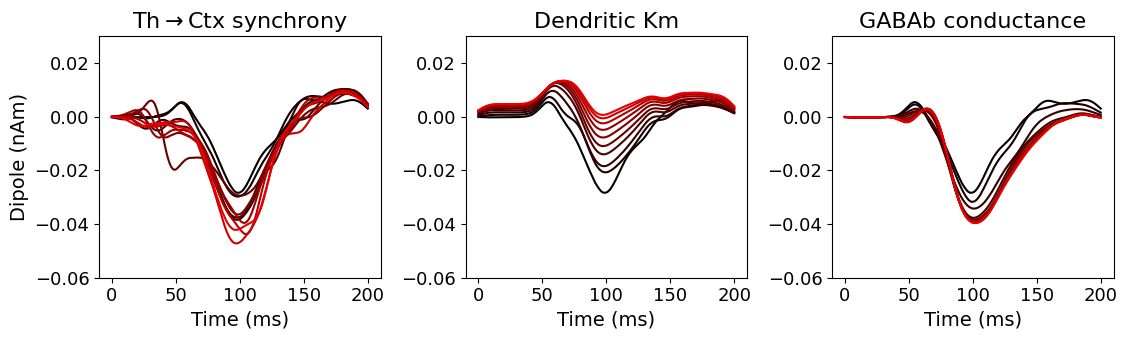

In [49]:
ticksize = 13
labelsize = 14
titlesize = 16

unique_labels = df['label'].unique()
title_dict = {
    'ff_gain_scale': 'Th$\\rightarrow$Ctx synchrony',
    'km_scale': 'Dendritic Km',
    'inh_gain_scale': 'GABAb conductance'}
times = np.linspace(0, tstop, len(dpl[0]))

plt.figure(figsize=(15,3.5))
for plot_idx, label_name in enumerate(unique_labels):

    cmap_color = 'r'
    colors = ['k', cmap_color] # first color is black, last is red
    cmap = LinearSegmentedColormap.from_list(
            "Custom", colors)

    plt.subplot(1, 4, plot_idx+1)
    mask = df['label'] == label_name
    dpl_data = df[mask]['dpl'].values

    for sim_idx in range(num_sims):
        sweep_color = cmap(sim_idx / num_sims)
        plt.plot(times, dpl_data[sim_idx], linewidth=1.5, color=sweep_color)

    plt.title(title_dict[label_name], fontsize=titlesize)
    plt.xticks(fontsize=ticksize)
    plt.yticks(fontsize=ticksize)
    plt.xlabel('Time (ms)', fontsize=labelsize)

    plt.ylim(-0.06, 0.03)

plt.subplot(1,4,1)
plt.ylabel('Dipole (nAm)', fontsize=labelsize)



plt.tight_layout()